# Segmentation Algorithm Workflows

This notebook demonstrates IceFloeTracker.jl's segmentation algorithms 
with very basic examples of their use.

In [ ]:
# Setup environment
using Pkg
Pkg.add("IceFloeTracker"; rev="main")
Pkg.add("Images")

In [4]:
# Load packages
using IceFloeTracker: LopezAcosta2019, LopezAcosta2019Tiling, Watkins2025GitHub
using Images: erode, segment_mean, labels_map, SegmentedImage, RGB, mosaicview

## Load the images

Load the dataset from https://github.com/danielmwatkins/ice_floe_validation_dataset using the `Watkins2025GitHub` data loader.

In [5]:
data_loader = Watkins2025GitHub(; ref="a451cd5e62a10309a9640fbbe6b32a236fcebc70")

Watkins2025GitHub("a451cd5e62a10309a9640fbbe6b32a236fcebc70", "https://github.com/danielmwatkins/ice_floe_validation_dataset/", "data/validation_dataset/validation_dataset.csv", "/tmp/Watkins2025")

The available data are listed in the metadata field:

In [6]:
data_loader().metadata

┌ Warning: In /tmp/Watkins2025/a451cd5e62a10309a9640fbbe6b32a236fcebc70/validation_dataset.csv line 381 has 0 fields but 28 fields are expected. Skipping row.
└ @ TextParse /home/vscode/.julia/packages/TextParse/bX5Ws/src/csv.jl:390


378×28 DataFrame
 Row │ case_number  region          start_date  center_lon  center_lat  center ⋯
     │ Int64        String          Dates.Date  Float64     Float64     Int64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │           1  baffin_bay      2022-09-11    -91.5275     77.801    -9625 ⋯
   2 │           1  baffin_bay      2022-09-11    -91.5275     77.801    -9625
   3 │           2  baffin_bay      2015-03-12    -81.9643     76.0579   -9125
   4 │           2  baffin_bay      2015-03-12    -81.9643     76.0579   -9125
   5 │           3  baffin_bay      2012-04-19    -79.5793     75.6372   -8875 ⋯
   6 │           3  baffin_bay      2012-04-19    -79.5793     75.6372   -8875
   7 │           4  baffin_bay      2019-09-25    -76.8094     79.3029   -6125
   8 │           4  baffin_bay      2019-09-25    -76.8094     79.3029   -6125
  ⋮  │      ⋮             ⋮             ⋮           ⋮           ⋮          ⋮   ⋱
 372 │         186  sea_of_okhostk  2017-05-23    155.183      59.6011  -11625 ⋯
 373 │         187  sea_of_okhostk  2013-04-29    155.731      59.7278  -11875
 374 │         187  sea_of_okhostk  2013-04-29    155.731      59.7278  -11875
 375 │         188  sea_of_okhostk  2015-03-12    156.838      57.6608  -13375
 376 │         188  sea_of_okhostk  2015-03-12    156.838      57.6608  -13375 ⋯
 377 │         189  sea_of_okhostk  2012-04-26    163.086      61.4172  -14875
 378 │         189  sea_of_okhostk  2012-04-26    163.086      61.4172  -14875
                                                 23 columns and 363 rows omitted

For the example, we choose a single case from Baffin Bay in May 2022.

In [7]:
dataset = data_loader(c-> c.case_number == 6 && c.satellite == "terra")
case = first(dataset)

┌ Warning: In /tmp/Watkins2025/a451cd5e62a10309a9640fbbe6b32a236fcebc70/validation_dataset.csv line 381 has 0 fields but 28 fields are expected. Skipping row.
└ @ TextParse /home/vscode/.julia/packages/TextParse/bX5Ws/src/csv.jl:390


IceFloeTracker.ValidationDataCase("006-baffin_bay-100km-20220530-terra-250m", Dict{Symbol, Any}(:sea_ice_fraction => 1.0, :visible_floes => "yes", :visible_landfast_ice => "no", :region => "baffin_bay", :cloud_category_manual => "thin", :qa_reviewer => "emma", :center_x => -762500, :modis_cloud_error => "no", :start_date => Dates.Date("2022-05-30"), :satellite => "terra"…), ColorTypes.RGBA{FixedPointNumbers.N0f8}[RGBA{N0f8}(0.651,0.675,0.722,1.0) RGBA{N0f8}(0.608,0.635,0.675,1.0) … RGBA{N0f8}(0.831,0.835,0.812,1.0) RGBA{N0f8}(0.824,0.827,0.835,1.0); RGBA{N0f8}(0.71,0.741,0.784,1.0) RGBA{N0f8}(0.675,0.702,0.741,1.0) … RGBA{N0f8}(0.882,0.882,0.851,1.0) RGBA{N0f8}(0.835,0.835,0.835,1.0); … ; RGBA{N0f8}(0.816,0.831,0.843,1.0) RGBA{N0f8}(0.839,0.855,0.867,1.0) … RGBA{N0f8}(0.898,0.902,0.918,1.0) RGBA{N0f8}(0.773,0.776,0.792,1.0); RGBA{N0f8}(0.882,0.886,0.902,1.0) RGBA{N0f8}(0.867,0.871,0.886,1.0) … RGBA{N0f8}(0.839,0.843,0.851,1.0) RGBA{N0f8}(0.776,0.78,0.788,1.0)], ColorTypes.RGBA{FixedPoi

The data include the true-color image:

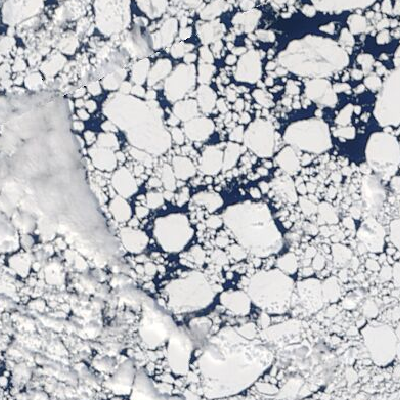

In [8]:
truecolor = RGB.(case.modis_truecolor) # TODO: remove RGB cast

... a false-color image:

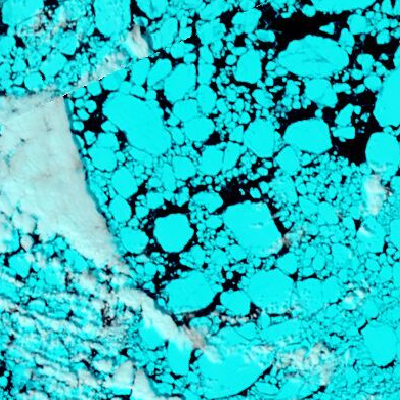

In [9]:
falsecolor = RGB.(case.modis_falsecolor) # TODO: remove RGB cast

... and a landmask, which in this particular case is empty:

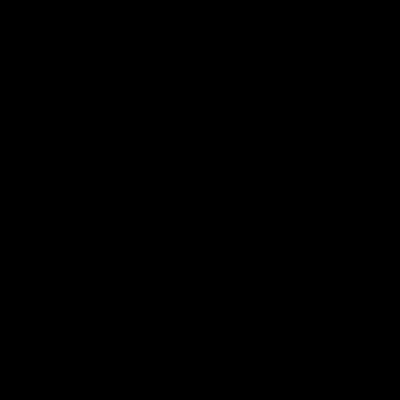

In [10]:
landmask = RGB.(case.modis_landmask) # TODO: remove RGB cast

## Run the segmentation algorithm

The segmentation algorithm is an object with parameters as follows:

In [11]:
segmentation_algorithm = LopezAcosta2019()

LopezAcosta2019(Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0])

If we wanted to modify the options, we could include those in the call above. 
See the documentation for `LopezAcosta2019` for details.
The default parameters are as follows:

In [12]:
dump(segmentation_algorithm)

LopezAcosta2019
  landmask_structuring_element: Array{Bool}((99, 99)) Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]


Run the algorithm as follows:

In [13]:
segments = segmentation_algorithm(truecolor, falsecolor, landmask)

┌ Info: building landmask
└ @ IceFloeTracker /workspaces/IceFloeTracker.jl/src/segmentation-lopez-acosta-2019.jl:24
┌ Info: Building cloudmask
└ @ IceFloeTracker /workspaces/IceFloeTracker.jl/src/segmentation-lopez-acosta-2019.jl:27
┌ Info: Finding ice labels
└ @ IceFloeTracker /workspaces/IceFloeTracker.jl/src/segmentation-lopez-acosta-2019.jl:32
┌ Info: Sharpening truecolor image
└ @ IceFloeTracker /workspaces/IceFloeTracker.jl/src/segmentation-lopez-acosta-2019.jl:35
┌ Info: Normalizing truecolor image
└ @ IceFloeTracker /workspaces/IceFloeTracker.jl/src/segmentation-lopez-acosta-2019.jl:43
┌ Info: Discriminating ice/water
└ @ IceFloeTracker /workspaces/IceFloeTracker.jl/src/segmentation-lopez-acosta-2019.jl:49
┌ Info: Segmenting floes part 1/3
└ @ IceFloeTracker /workspaces/IceFloeTracker.jl/src/segmentation-lopez-acosta-2019.jl:55
┌ Info: Segmenting floes part 2/3
└ @ IceFloeTracker /workspaces/IceFloeTracker.jl/src/segmentation-lopez-acosta-2019.jl:61
┌ Info: Building watersheds


Segmented Image with:
  labels map: 400×400 Matrix{Int64}
  number of labels: 65

To show the results with each segment marked using its mean color:

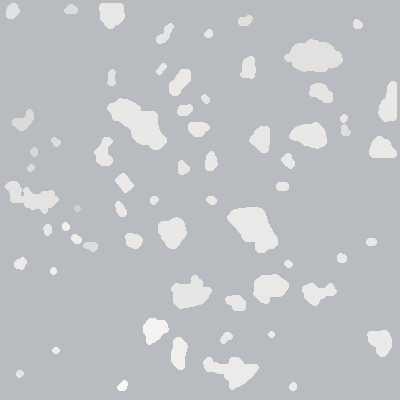

In [14]:
map(i -> segment_mean(segments, i), labels_map(segments))

We can do the same with the falsecolor image:

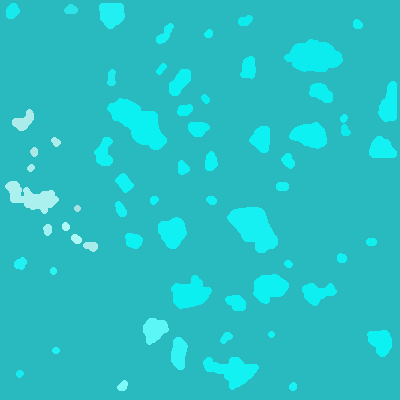

In [15]:
# Get the labels_map
segments_falsecolor = SegmentedImage(falsecolor, labels_map(segments))
map(i -> segment_mean(segments_falsecolor, i), labels_map(segments_falsecolor))

Let's compare the segmented output to the manually validated labels:

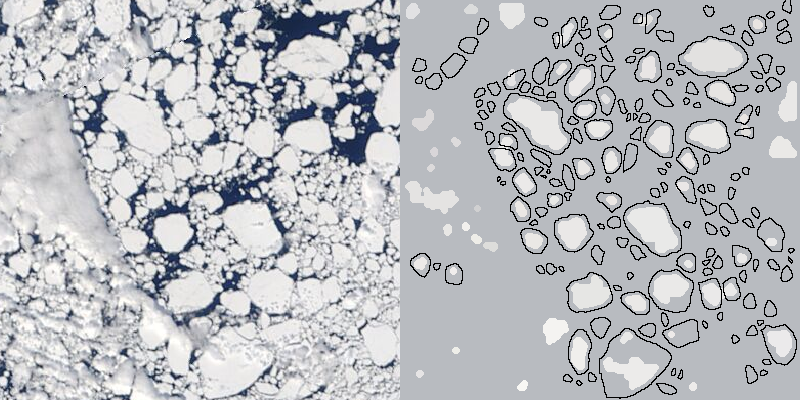

In [16]:
man_labels = case.validated_binary_floes
outlines = man_labels .- erode(man_labels)
seg_vs = map(i -> segment_mean(segments, i), labels_map(segments))
mosaicview(truecolor, seg_vs .* (1 .- Float64.(outlines)), nrow=1)

## Run the segmentation algorithm with tiling
The "tiling" version of the algorithm is an object:

In [17]:
segmentation_algorithm_with_tiling = LopezAcosta2019Tiling()

LopezAcosta2019Tiling((rblocks = 2, cblocks = 2), (prelim_threshold = 0.43137254901960786, band_7_threshold = 0.7843137254901961, band_2_threshold = 0.7450980392156863, ratio_lower = 0.0, ratio_offset = 0.0, ratio_upper = 0.75), (white_threshold = 25.5, entropy_threshold = 4, white_fraction_threshold = 0.4), (gamma = 1.5, gamma_factor = 1.3, gamma_threshold = 220), (se_disk1 = Bool[0 1 0; 1 1 1; 0 1 0], se_disk2 = Bool[0 0 … 0 0; 0 1 … 1 0; … ; 0 1 … 1 0; 0 0 … 0 0], se_disk4 = Bool[0 0 … 0 0; 0 1 … 1 0; … ; 0 1 … 1 0; 0 0 … 0 0]), (radius = 10, amount = 2.0, factor = 255.0), (band_7_threshold = 0.0196078431372549, band_2_threshold = 0.9019607843137255, band_1_threshold = 0.9411764705882353, band_7_threshold_relaxed = 0.0392156862745098, band_1_threshold_relaxed = 0.7450980392156863, possible_ice_threshold = 0.29411764705882354, k = 3), (radius = 10, amount = 2, factor = 0.5), 0.1)

It has more configurable parameters. 
For details, see the documentation of `LopezAcosta2019Tiling`.
The default parameters are as follows:

In [18]:
dump(segmentation_algorithm_with_tiling)

LopezAcosta2019Tiling
  tile_settings: @NamedTuple{rblocks::Int64, cblocks::Int64}
    rblocks: Int64 2
    cblocks: Int64 2
  cloud_mask_thresholds: @NamedTuple{prelim_threshold::Float64, band_7_threshold::Float64, band_2_threshold::Float64, ratio_lower::Float64, ratio_offset::Float64, ratio_upper::Float64}
    prelim_threshold: Float64 0.43137254901960786
    band_7_threshold: Float64 0.7843137254901961
    band_2_threshold: Float64 0.7450980392156863
    ratio_lower: Float64 0.0
    ratio_offset: Float64 0.0
    ratio_upper: Float64 0.75
  adapthisteq_params: @NamedTuple{white_threshold::Float64, entropy_threshold::Int64, white_fraction_threshold::Float64}
    white_threshold: Float64 25.5
    entropy_threshold: Int64 4
    white_fraction_threshold: Float64 0.4
  adjust_gamma_params: @NamedTuple{gamma::Float64, gamma_factor::Float64, gamma_threshold::Int64}
    gamma: Float64 1.5
    gamma_factor: Float64 1.3
    gamma_threshold: Int64 220
  structuring_elements: @NamedTuple{se_disk

In [19]:
segments = segmentation_algorithm_with_tiling(truecolor, falsecolor, landmask)

┌ Warning: using undilated landmask as dilated
└ @ IceFloeTracker /workspaces/IceFloeTracker.jl/src/segmentation-lopez-acosta-2019-tiling.jl:83


Segmented Image with:
  labels map: 400×400 Matrix{Int64}
  number of labels: 346

To show the results with each segment marked using its mean color:

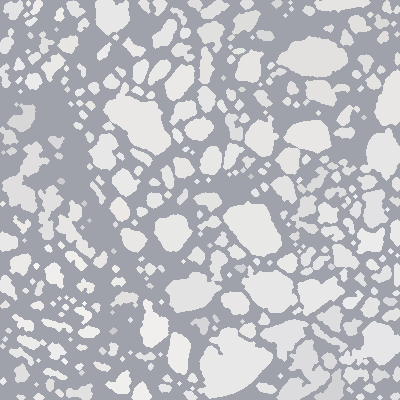

In [20]:
map(i -> segment_mean(segments, i), labels_map(segments))

With the falsecolor image:

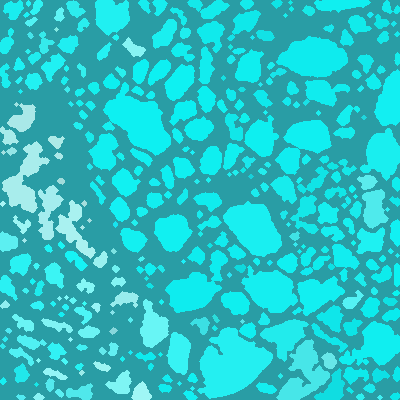

In [21]:
# Get the labels_map
segments_falsecolor = SegmentedImage(falsecolor, labels_map(segments))
map(i -> segment_mean(segments_falsecolor, i), labels_map(segments_falsecolor))

Let's compare the segmented output to the manually validated labels:

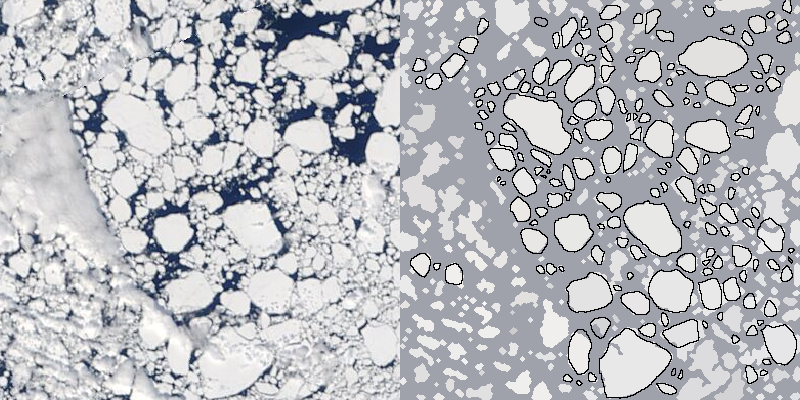

In [22]:
man_labels = case.validated_binary_floes
outlines = man_labels .- erode(man_labels)
seg_vs = map(i -> segment_mean(segments, i), labels_map(segments))
mosaicview(truecolor, seg_vs .* (1 .- Float64.(outlines)), nrow=1)